# Experimenting with LIME Kernels 

This module is used for testing which kernel weight that makes linear LIME fails. I used the pretrained model imported from open source of LIME ([link](href="https://github.com/marcotcr/lime")). In particular, the basic image classifier is used for distiguishing cats and dogs. Please jump to the bottom of the page to view the failed cases of LIME. 

Inputs: 
- A cat&dog image for testing the model
- kernels: 
    - gaussian
    - gaussian radio basis
    - bessel 
    - quational quadartic
    - multiquadric 
    - inverse multiquadratic
    - circular
    - cauchy
- kernel_width

Outputs: Explanation of the classifier, i.e., which part of the image that the model could explain as the dog.

*Author: Ruonan (Elizabeth) Zhao*

*Date: 12/11/2019*


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import lime

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

## Import the Test Image

In [9]:
from lime import lime_image

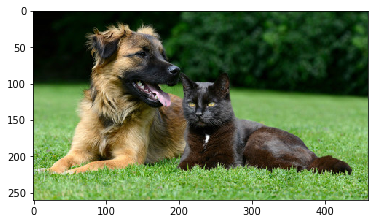

In [21]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('Downloads/data/dog.png')
plt.imshow(img)

In [17]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

## Run LIME algorithm to Explain the Image

In [18]:
model = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /Users/ruonanzhao/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:09<00:00, 11.7MB/s] 


In [23]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('Downloads/data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [26]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [28]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.91877294, 255, 'Leonberg'),
 (0.030622141, 235, 'German_shepherd'),
 (0.019369954, 225, 'malinois'),
 (0.014042653, 174, 'Norwegian_elkhound'),
 (0.010169122, 224, 'groenendael'))

In [29]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [30]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [31]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

255

### Default LIME exaplainer

In [32]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [33]:
from skimage.segmentation import mark_boundaries

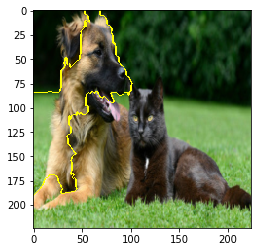

In [72]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

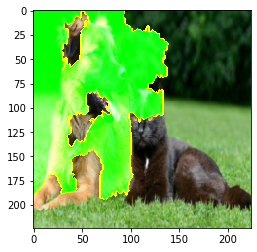

In [73]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

LIME explaines the green area as the dog, which means that it works well. 

### Changing the Width of Kernel: 

In [36]:
explainer = lime_image.LimeImageExplainer(kernel_width = .5)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [37]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

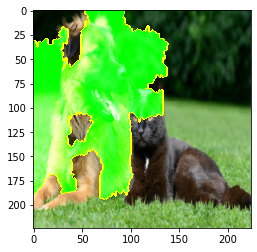

In [38]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### Changing the kernel width to 10:

In [39]:
explainer = lime_image.LimeImageExplainer(kernel_width = 10)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

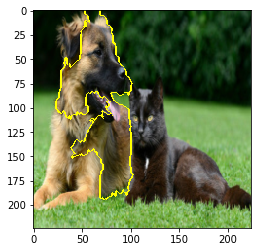

In [40]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

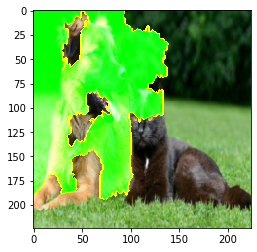

In [41]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### Changing the kernel function - 1st try:
*(skip 2-5th try as they're just for tedious experiments)*

In [42]:
def k_1(d, kernel_width):
    return np.abs(-d**2 / kernel_width **2)

In [43]:
explainer = lime_image.LimeImageExplainer(kernel = k_1)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

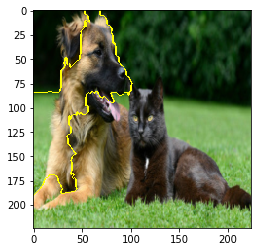

In [44]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

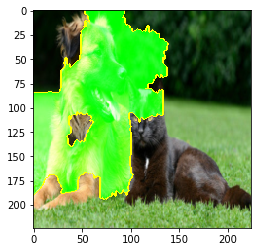

In [45]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

change of kernel -- 2nd try

In [46]:
def k_2(d, kernel_width):
    return np.cos(-d**2 / kernel_width **2)**2

In [47]:
explainer = lime_image.LimeImageExplainer(kernel = k_2)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

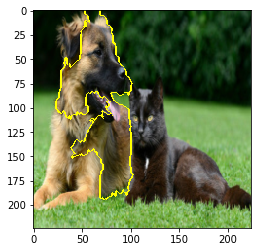

In [48]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

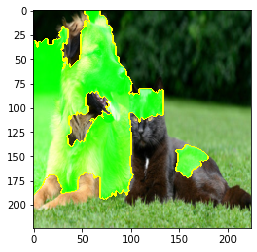

In [49]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

change of kernel -- 3rd try

In [50]:
def k_3(d, kernel_width):
    return d/kernel_width

In [51]:
explainer = lime_image.LimeImageExplainer(kernel = k_2)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

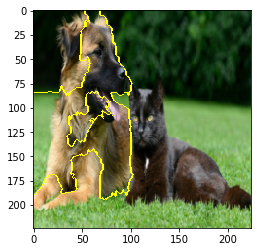

In [52]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [53]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

change kernel -- 4th try

In [59]:
def k_4(d, kernel_width):
    return d+kernel_width

In [60]:
explainer = lime_image.LimeImageExplainer(kernel = k_4)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [61]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

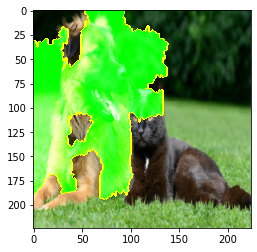

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

5th try

In [65]:
def k_5(d, kernel_width):
    return (d/kernel_width)**3

In [66]:
explainer = lime_image.LimeImageExplainer(kernel = k_4)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

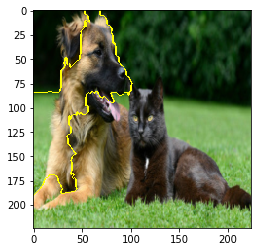

In [67]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

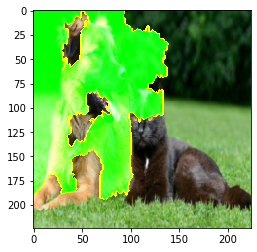

In [68]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### 6th try: Use Gaussian radial basis function (RBF), gamma = 1 (>0)

In [74]:
explainer = lime_image.LimeImageExplainer(kernel_width = 1)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

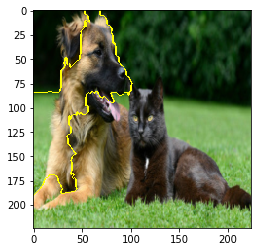

In [75]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [77]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### 7th try: Bessel function of the first kind Kernel

In [78]:
def k_7(d, kernel_width):
    return np.i0(np.sqrt(kernel_width)*d) 

In [79]:
explainer = lime_image.LimeImageExplainer(kernel = k_7)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

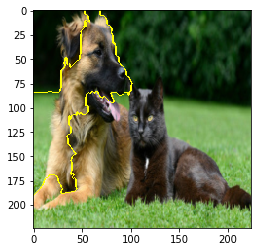

In [80]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

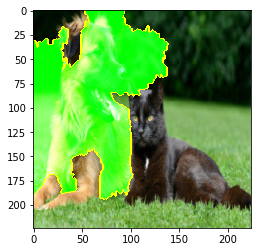

In [81]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### 8th try: Qational Quadratic Kernel

In [91]:
def k_8(d, kernel_width):
    return 1- (d**2 / (d**2 + 4))

In [92]:
explainer = lime_image.LimeImageExplainer(kernel = k_8)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

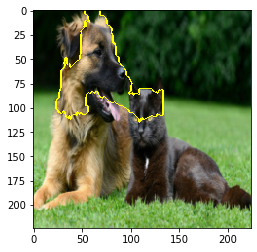

In [93]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [94]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### 9th try: multiquadric kernel

In [95]:
def k_9(d, kernel_width):
    return np.sqrt(d**2 + 4)

In [96]:
explainer = lime_image.LimeImageExplainer(kernel = k_9)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [97]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

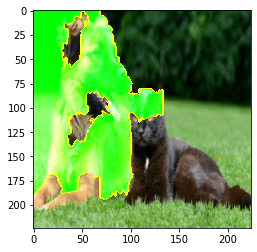

In [98]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### 10th try: inverse multiquadric kernel

In [99]:
def k_10(d, kernel_width):
    return 1 / (d**2 + 4)

In [100]:
explainer = lime_image.LimeImageExplainer(kernel = k_10)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

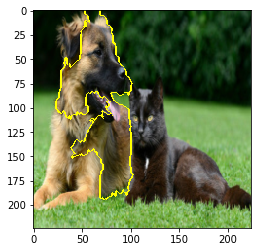

In [101]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

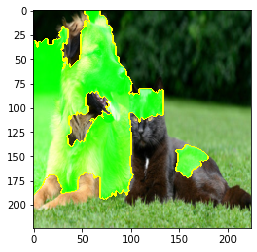

In [102]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#### 11th try: circular kernel

In [117]:
def k_11(d, kernel_width):
    return - np.log (d + 1)

In [118]:
explainer = lime_image.LimeImageExplainer(kernel = k_11)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:186: RuntimeWarning: invalid value encountered in sqrt
  sample_weight = np.sqrt(sample_weight)


ValueError: array must not contain infs or NaNs

#### 12th try: cauchy kernel

In [119]:
def k_12(d, kernel_width):
    return 1/ (1+ (d**2 )/ (kernel_width **2))

In [120]:
explainer = lime_image.LimeImageExplainer(kernel = k_12)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

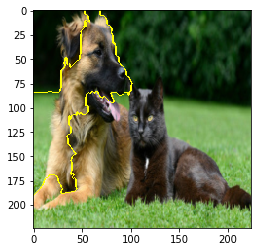

In [121]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

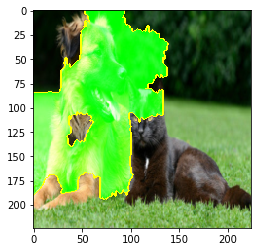

In [122]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

kernel width = 1:

In [126]:
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = 1)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

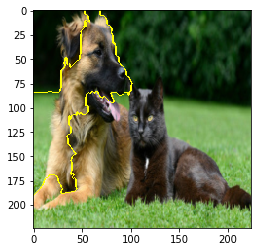

In [127]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

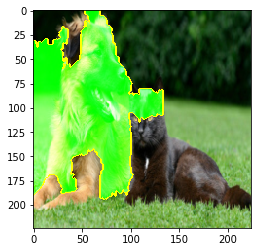

In [128]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

## testing cauchy kernel

In [131]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function
    

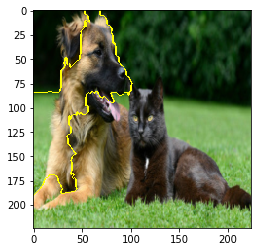

In [132]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

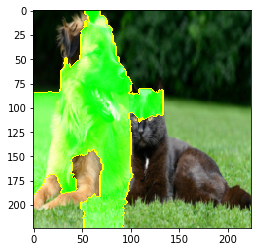

In [133]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [134]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

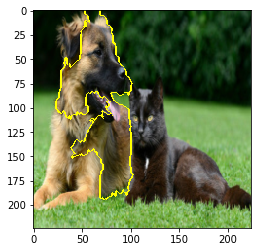

In [135]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

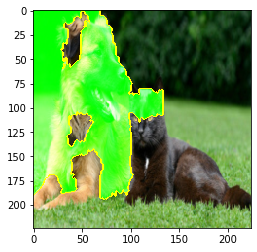

In [136]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [137]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

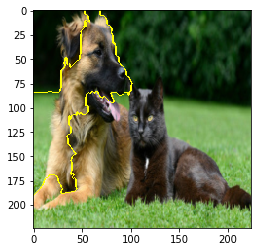

In [138]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

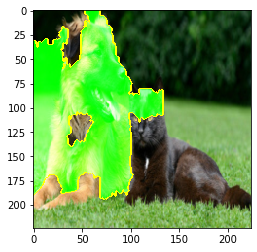

In [139]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [140]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

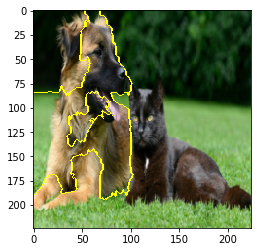

In [141]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [142]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [143]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

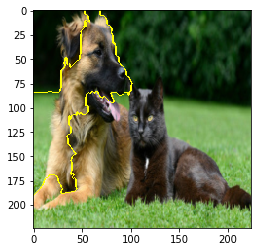

In [144]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

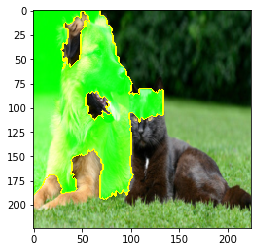

In [145]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [146]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

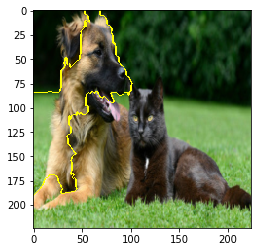

In [147]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

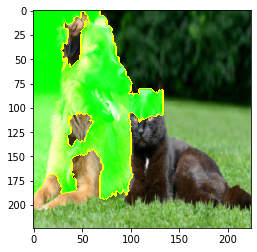

In [148]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [149]:
kw = np.random.randn()
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

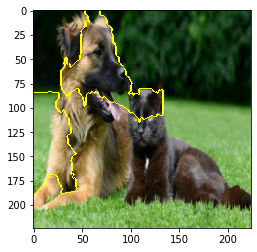

In [150]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

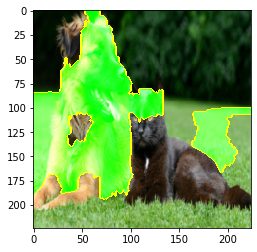

In [151]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [152]:
kw = np.random.randn()
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width -0.061813116003695184


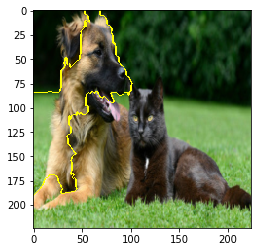

In [153]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

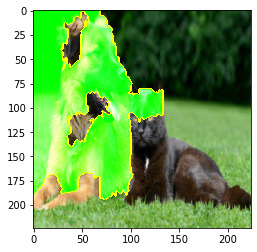

In [154]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [155]:
kw = np.random.randn()
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 0.42767289718178886


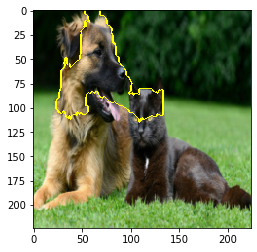

In [156]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [157]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [158]:
kw = np.random.randn()
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width -0.028672044505499136


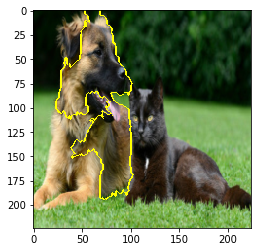

In [159]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

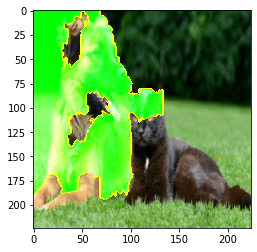

In [160]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [162]:
kw = np.random.randn()
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 1.165482209200217


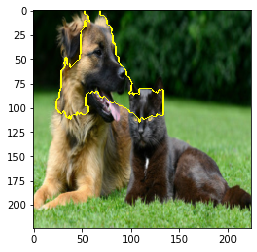

In [163]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

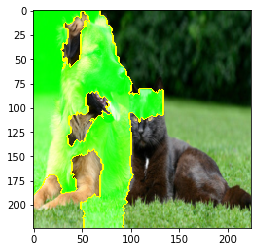

In [164]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [165]:
kw = 2
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 2


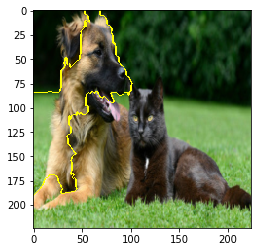

In [166]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

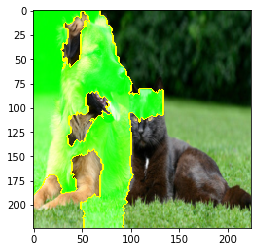

In [167]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [168]:
kw = -2
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width -2


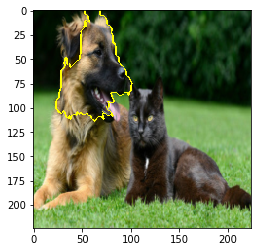

In [169]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

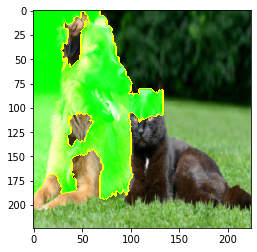

In [170]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [171]:
kw = 0.002
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 0.002


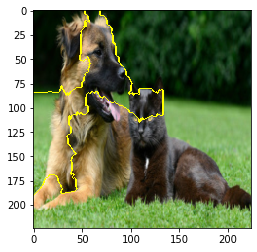

In [172]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

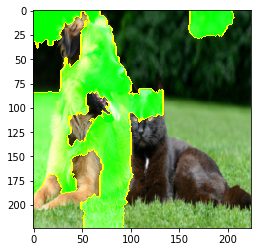

In [173]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [174]:
kw = 0.000002
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 2e-06


In [175]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

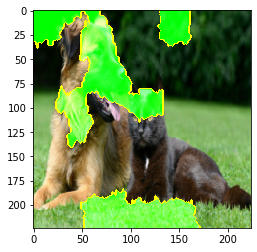

In [176]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [177]:
kw = 2e-10
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 2e-10


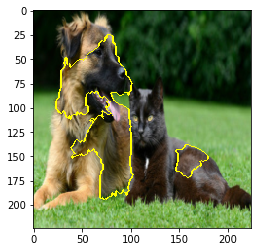

In [178]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [179]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [191]:
kw = 2e-20
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 2e-20


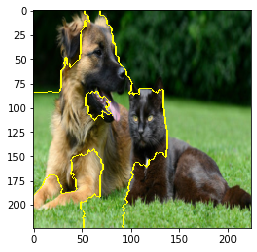

In [200]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [204]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [183]:
kw = 2e3
print("kernel width", kw)
explainer = lime_image.LimeImageExplainer(kernel = k_12, kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                     batch_predict, # classification function
                                     top_labels=5, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function

kernel width 2000.0


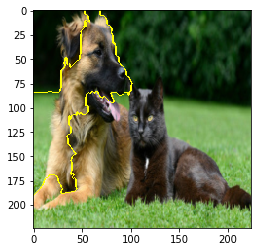

In [184]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

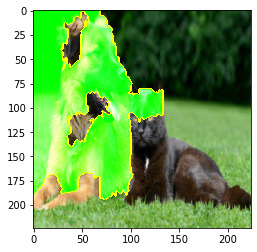

In [188]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

## Extreme Case of Kernel Width:
LIME fails in these cases

In [207]:
kw = 2e-6

explainer = lime_image.LimeImageExplainer(kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [208]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

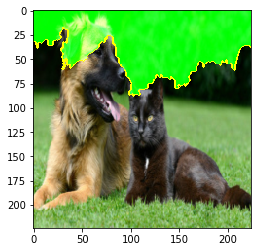

In [209]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [210]:
kw = 2e-3

explainer = lime_image.LimeImageExplainer(kernel_width = kw)
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

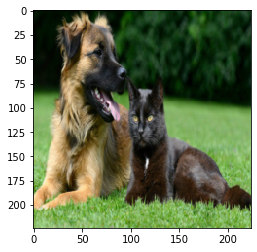

In [211]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

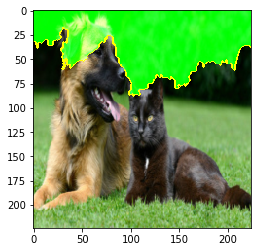

In [212]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)